In [229]:
# libraries needed to be installed:

library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)
library(forcats)

# Classification of Potential Heart Disease Cases - a Data Science Project

# *Introduction:*

Heart disease is caused by irregularities to the heart structure and may cause implications to its function, most often heavily impacting a person’s quality of life. To investigate variables which may be associated with such problems, the “Heart Disease Dataset”, the “Cleveland Clinic Foundation” data donated in 1988 will be the focus of this project. This dataset contains 14 used attributes which provide insight into participants health through a variety of measurements (refer to code). Given the attributes of age (years), cholesterol level in the bloodstream (mg/dL), and resting blood pressure (mm Hg), the project aims to predict whether or not a person will suffer from heart disease. 


# *Methods:*

## Choosing predictors & wrangling data:                                
To conduct our data analysis, age, cholesterol level (cholesterol_level), and resting blood pressure (blood_pressure) have been selected as predictors for diagnosis. 
Existing studies have shown that these variables are highly related to heart disease (Damen et al., 2016; Weitzman et al., 2006). Firstly, the effects of aging are known to increase one’s risk for heart disease due to stiffening of the heart’s left ventricle and general deterioration of its surrounding blood vessels. Secondly, high levels of cholesterol can lead to deposits in arteries around the heart which increases heart disease risk. Finally, high resting blood pressure is also known to increase one’s risk for heart complications; the increased strain on the arteries causes them to become less elastic and decreases the blood flow to the heart muscles. Other variables do not appear to have as strong of a correlation with heart disease and/or are not fitting for classification models as they do not provide a varying quantitative value. Thus, only these three variables have been chosen as predictors to ensure an accurate classification model. 

The data was drawn from an online database (“https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data”) and wrangled accordingly to label all columns, selected for the four variables of interest, and the diagnosis column was converted to a “factor” such that it is treated categorically (beneficial for future code). 


In [230]:
# wrangling

library(readxl)
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
download.file(url, destfile = "processed.cleveland.data")

heart_data_initial <- read.table("processed.cleveland.data", sep = ",") %>%
rename(
age = V1, # (years)
sex = V2, # 1 == male, 0 == female
chest_pain_type = V3, # 1 == typical angina, 2 == atypical angina, 3 == non-anginal pain, 4 == asymptomatic
resting_blood_pressure = V4, # (mmHg)
cholesterol_level = V5, # (mg/dl)
fasting_blood_sugar = V6, # 1 == higher than 120 mg/dl, 0 == not higher than 120 mg/dl
resting_electrocardiographic_results = V7, # 0 == normal, 1 == ST-T wave abnormality, 2 == probable or definite left ventricular hypertrophy
maximum_heart_rate_achieved = V8, # (bpm?) *unit not stated
exercise_induced_angina = V9, # 1 == yes, 0 == no
excercise_induced_ST_depression = V10, # *unit not stated
slope = V11, # slope of the peak exercise ST segment. 1 == upsloping, 2 == flat, 3 == downsloping
major_vessels_coloured = V12, # number of major vessels (0-3) colored by flourosopy
thal = V13, # 3 == normal, 6 == fixed defect, 7 == reversable defect
diagnosis = V14) %>% # 0 == no heart disease, 1 to 4 == heart disease, with different levels of severity (4 is most severe)

na.omit(age, resting_blood_pressure, cholesterol_level) %>%
select(age, resting_blood_pressure, cholesterol_level, diagnosis) %>%
mutate(diagnosis = as.factor(diagnosis)) 
  

heart_data_initial

age,resting_blood_pressure,cholesterol_level,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


Table 1.                            
The wrangled and clean heart-disease dataset we are using in this project. Each row represents a patient. The first 3 columns contain numerical data of the patients' Age, Resting Blood Pressure, and Cholesterol Level, respectively. These will be used as the predictors in our classification analysis. The rightmost column contains categorical data of the patients' Diagnosis (converted into the factor type for analytical purposes), where 0 represents no heart disease, and 1 to 4 represents levels of severity of the disease (4 being the most severe). This will be the variable we are trying to predict.

In [231]:
# number of each diagnosis class

diagnosis_count_full_set <- heart_data_initial %>%
group_by(diagnosis) %>%
summarize(n = n())
diagnosis_count_full_set

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
0,164
1,55
2,36
3,35
4,13


Table 2.                               
The number of observations with each diagnosis, in the full dataset.


.

## Preliminary exploratory data analysis and visualizations:

### Making adjustments:                                                  
In the wrangling above, the data was summarized into one table to count the number of observations in each diagnosis “class”. The data was shown to be quite imbalanced where diagnosis “0”, no heart disease, had more observations than all the other diagnosis classes (1-4) combined. Given that a classification model is the end goal, imbalance could heavily impact the accuracy of the model’s predictions if the k-value is set to a relatively large number. Furthermore, existing research suggests that our predictors (age, cholesterol level and resting blood pressure) may not be able to predict the severity of heart disease with reasonable accuracy. Thus, upon further consideration, the data was re-wrangled by combining the diseased classes 1 through 4 into a single factor (labeled "diseased") such that the balancing issue was resolved and the model could predict diagnosis with greater accuracy. 

The dataset was then split into training (75%) and test data (25%). Then the preliminary exploratory analysis began.

In [232]:
# combining levels 1 to 4 of 'diagnosis'

heart_data <- mutate(heart_data_initial, diagnosis = fct_collapse(heart_data_initial$diagnosis, diseased = c("1", "2", "3", "4")))  

In [233]:
heart_data

age,resting_blood_pressure,cholesterol_level,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,diseased
67,120,229,diseased
⋮,⋮,⋮,⋮
57,130,131,diseased
57,130,236,diseased
38,138,175,0


Table 3.                       
The heart_data set with all the diseased diagnoses (diagnosis values of 1, 2, 3, or 4) grouped into one single level (diseased). This makes it easier for the model later to analyse, and makes the data more balanced (due to there being relatively few observations in each of the original diseased levels).

In [234]:
# splitting the dataset, preliminary exploratory data analysis, and code for visualizations:

set.seed(9) 

heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

diagnosis_count <- heart_train %>%
group_by(diagnosis) %>%
summarize(n = n())
diagnosis_count

mean_age <- mean(heart_train$age)
standard_deviation_age <- sd(heart_train$age)

mean_resting_bp <- mean(heart_train$resting_blood_pressure)
standard_deviation_resting_bp <- sd(heart_train$resting_blood_pressure)

mean_cholesterol <- mean(heart_train$cholesterol_level)
standard_deviation_cholesterol <- sd(heart_train$cholesterol_level)

predictor_labels <- c('mean age', 'standard deviation age', 'mean resting bp', 'standard deviation resting bp', 'mean cholesterol', 'standard deviation cholesterol') %>%
data.frame() 
predictor_info <- c(mean_age, standard_deviation_age, mean_resting_bp, standard_deviation_resting_bp, mean_cholesterol, standard_deviation_cholesterol) %>%
data.frame() 
predictor_table <- cbind(predictor_labels, predictor_info)


# plot of age vs resting blood pressure
age_vs_resting_bp_plot <- ggplot(heart_train, aes(x=age, y=resting_blood_pressure, color = diagnosis)) +
geom_point() +
xlab('Age') +
ylab('Resting Blood Pressure (mmHg)') +
ggtitle('Age vs Resting Blood Pressure. \n Diagnosis: 0 = healthy, diseased = has heart disease') 


# plot of age vs cholesterol 
age_vs_cholesterol_plot <- ggplot(heart_train, aes(x=age, y=cholesterol_level, color = diagnosis)) +
geom_point() +
xlab('Age') +
ylab('Cholesterol Level (mg/dl)') +
ggtitle('Age vs Cholesterol Level. \n Diagnosis: 0 = healthy, diseased = has heart disease') 


# plot of cholesterol vs resting blood pressure
cholesterol_vs_resting_bp_plot <- ggplot(heart_train, aes(x=cholesterol_level, y=resting_blood_pressure, color = diagnosis)) +
geom_point() +
xlab('Cholesterol Level (mg/dL)') +
ylab('Resting Blood Pressure (mmHg)') +
ggtitle('Cholesterol vs Resting Blood Pressure. \n Diagnosis: 0 = healthy, diseased = has heart disease')


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
0,123
diseased,105


Table 4.                           
Number of healthy (diagnosis = 0) vs diseased (diagnosis = diseased) in the training set.

### Finalizing preliminary exploratory data analysis and visualizations:                                                  
Once again, the data was summarized into one table to count the number of observations in each diagnosis “class. Although there are slightly more observations with diagnosis “0” than “diseased”, the data is relatively balanced and upscaling was thus decided to be unnecessary. 

The means and standard deviations of our predictors were calculated from the heart training data which will be used to create our model (Table 2). Additionally, we paired our predictors with one another and scatter plots were made (refer to ggplot code): resting blood pressure vs. age, cholesterol level vs. age, resting blood pressure vs. cholesterol level (Figures 1-3 respectively). The points were colored based on diagnosis class (0 or diseased) to assist in visualizing trends between the predictors and diagnosis. 


Table 5.                      
The number of observations with each diagnosis, in the training dataset.

In [235]:
predictor_table

.,.
<chr>,<dbl>
mean age,54.267544
standard deviation age,8.895051
mean resting bp,131.938596
standard deviation resting bp,17.642203
mean cholesterol,244.350877
standard deviation cholesterol,48.979450


Table 6.                                      
Some info on the 3 predictor variables we are going to use: the mean and standard deviation of age, resting blood pressure, and cholesterol level (from the training dataset).

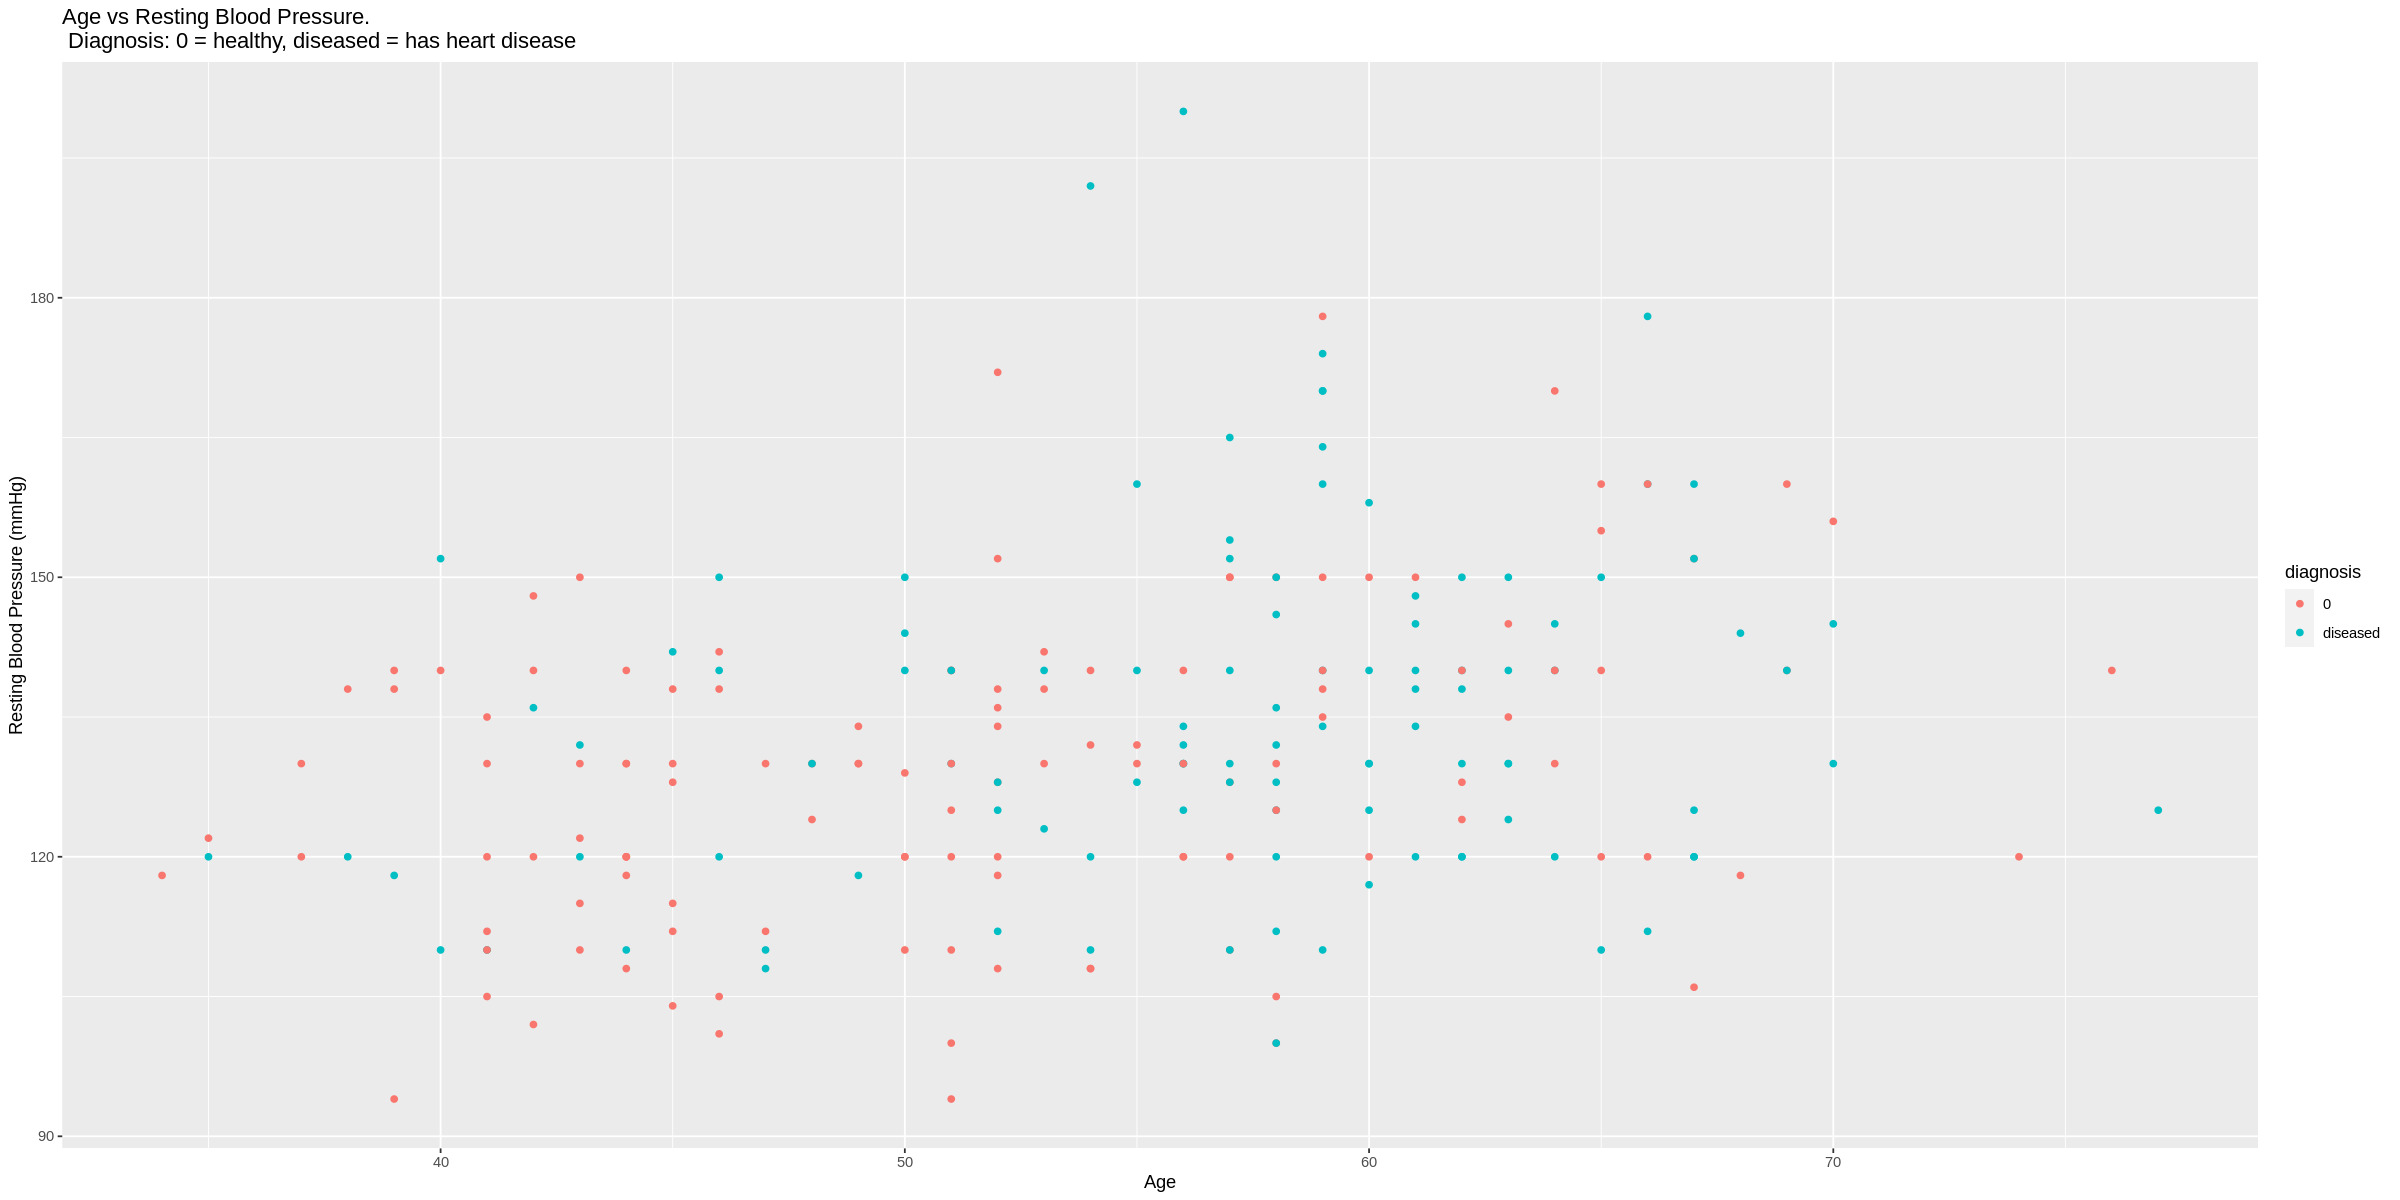

In [236]:
age_vs_resting_bp_plot

Figure 1.                        
Scatterplot of Resting Blood Pressure vs Age. This is to see if there are any noticeable trends in the distribution, or any clear relationship between these variables (which are to be used as predictors), so that we can account for them in the analysis. From this chart, there is no clear correlation between the variables. 

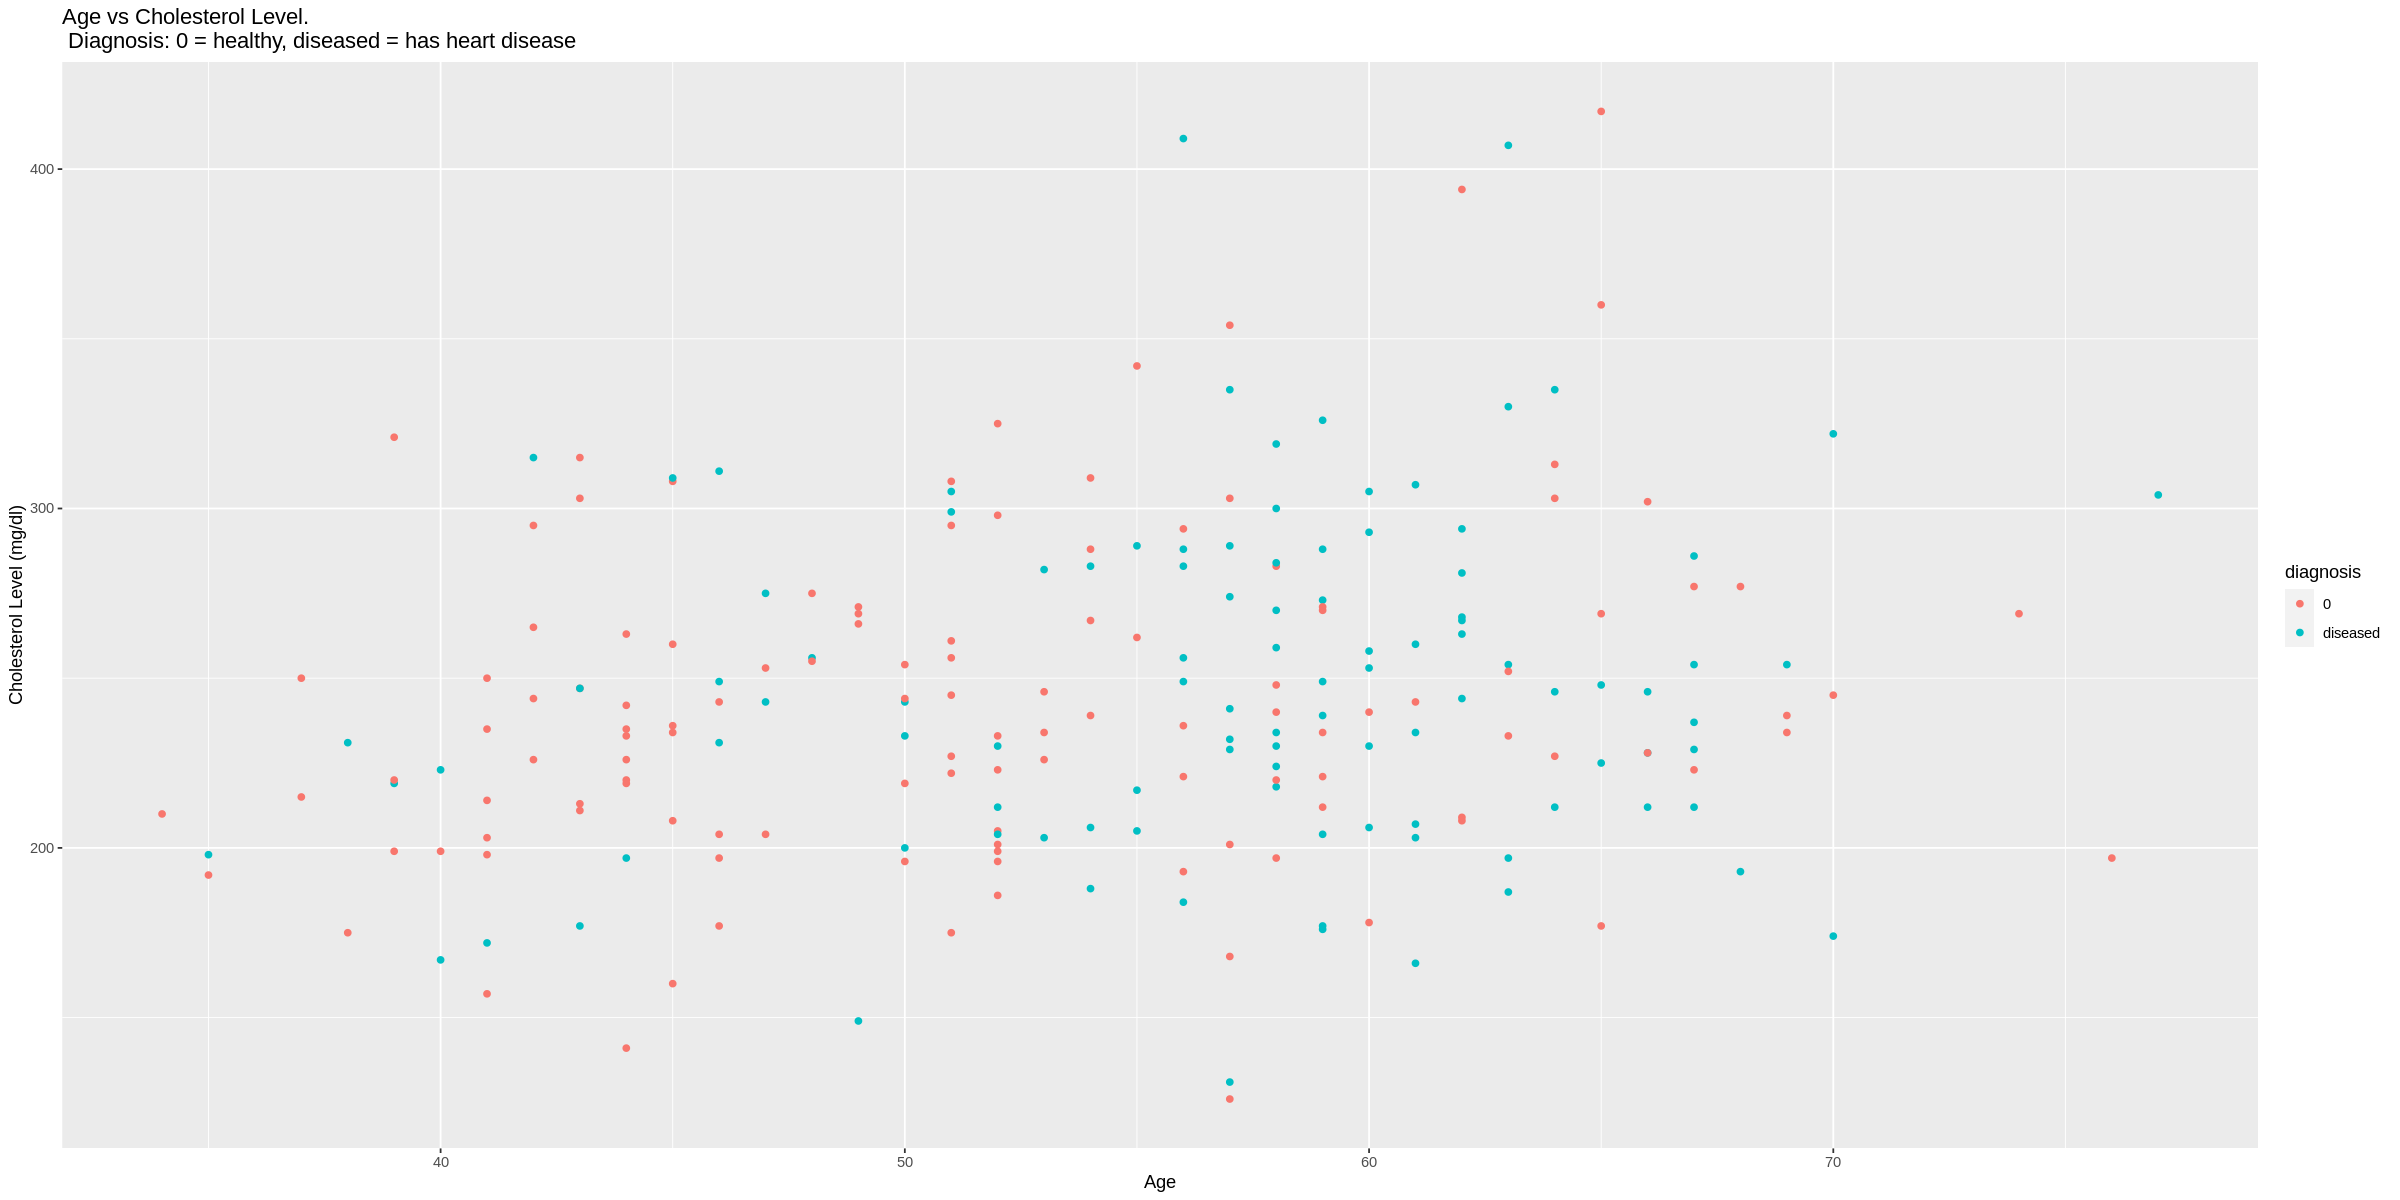

In [237]:
age_vs_cholesterol_plot

Figure 2.                                
Scatterplot of Cholesterol Level vs Age. This is to see if there are any noticeable trends in the distribution, or any clear relationship between these variables (which are to be used as predictors), so that we can account for them in the analysis. From this chart, there is no clear correlation between the variables. 

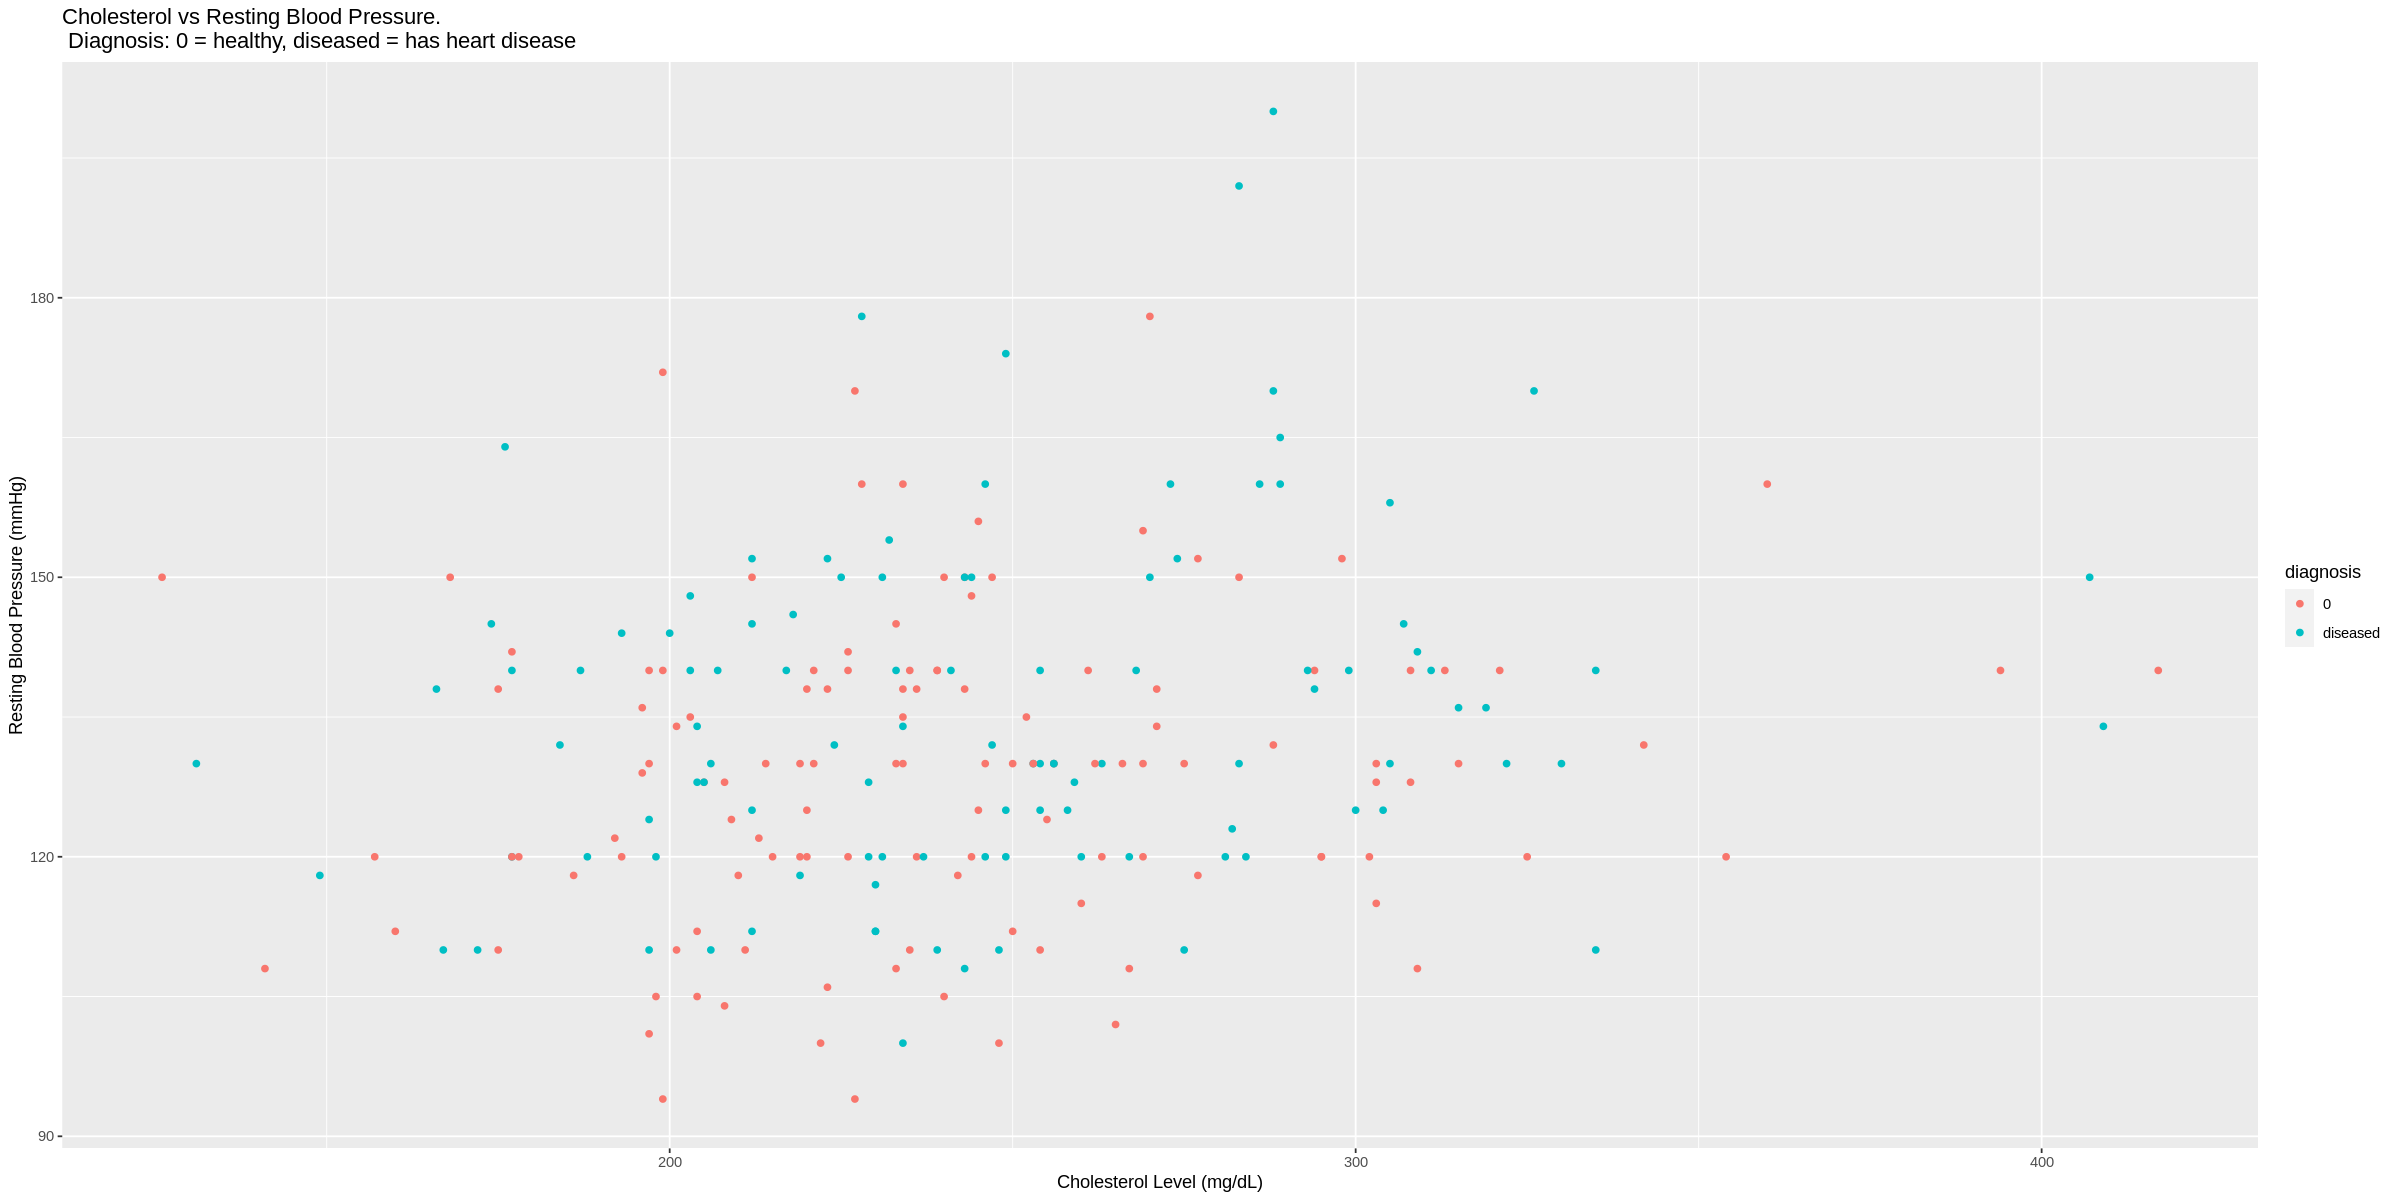

In [238]:
cholesterol_vs_resting_bp_plot

Figure 3.                       
Scatterplot of Resting Blood Pressure vs Cholesterol Level. This is to see if there are any noticeable trends in the distribution, or any clear relationship between these variables (which are to be used as predictors), so that we can account for them in the analysis. From this chart, there is no clear correlation between the variables. 


.

## Creating the classification model:                                                 
To make predictions of diagnosis, a K-nearest neighbors classification model was built. For context, K-nearest neighbors classifiers look at a new observation and refer to the “K” nearest neighbors with the most similar predictor values. Based on what the “majority” of those neighbors are labeled (their class), the classifier determines the class of the new observation. 

### “Trial” classification code with k = 3:                                                            
To begin, a trial classification model was made with the heart training data. The heart recipe scaled and centered all predictors to ensure that one predictor does not influence our model more than another. The model specification was made with neighbors equal to 3 (chosen arbitrarily), set to use KNN to perform classification, and the “weight_func” argument was set to “rectangular” such that straight-line distance was used to find the neighboring points and each neighbor had exactly 1 vote. By plugging in our new recipe and model specification into a workflow, a KNN model was made. 
The new KNN model performed predictions on the heart testing data and the “true” diagnosis of the heart testing data was compared with the KNN model predictions. A table (heart_prediction_accuracy) and confusion matrix (heart_mat) was used to show accuracy. 


In [239]:
# trial classification, k = 3 neighbours, accuracy assessment

# recipe:
heart_recipe <- recipe(diagnosis ~. , data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 


# model:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 3) %>%
       set_engine('kknn') %>%
       set_mode('classification')

# workflow & fit:
heart_fit <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = heart_train)

# predictions:
heart_test_predictions <- predict(heart_fit , heart_test) %>%
       bind_cols(heart_test)

# accuracy assessment (tibble):
heart_prediction_accuracy <- heart_test_predictions %>%
         metrics(truth = diagnosis, estimate = .pred_class) 

# accuracy assessment (confusion matrix):
heart_mat <- heart_test_predictions %>% 
       conf_mat(truth = diagnosis, estimate = .pred_class)

heart_prediction_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5733333
kap,binary,0.1477273


Table 7.                             
Accuracy of the model, when using k = 3 neighbours (chosen arbitrarily since this is just an initial trial run to check that it works properly, and to get an idea of the predicted results).

In [240]:
heart_mat

          Truth
Prediction  0 diseased
  0        23       14
  diseased 18       20

Table 8.                                  
Confusion matrix of the predictions against the real values. Shows how many of the predictions are correct, and how many are incorrect, in what ways (predicted no disease when there was disease, predicted severe disease when it was less severe, etc.)


.

### Tuning and finding the optimal k-value                                      
To choose the best parameter K for our classification model, 10-fold cross-validation was performed. This was done by splitting our overall training data into 10 equally sized chunks. The proportion of different diagnosis classes (“0” and “1”) in each chunk was set to be similar to the training data using the “strata=diagnosis” argument. Note that cross-validation works by selecting one chunk as the validation set and using the remaining 9 chunks as training sets. 
The aforementioned 10-fold cross validation was used to calculate accuracy for a range of different k-values. The range of different k-values was created as a data frame with numbers 1 through 50 called “gridvals”. Additionally, a new model specification was created named “knn_tune” for tuning neighbors. Plugging in “knn_tune”, the recipe from the “”Trial” classification code”, and the data frame “gridvals” into a workflow, the accuracy values were collected (collect_metrics). The accuracy for different k-values was plotted as a scatterplot and the optimal k-value was chosen (the k value that produced the highest accuracy). 


In [241]:
# vfold:
heart_vfold <- vfold_cv(heart_train, v = 10, strata = diagnosis)

In [242]:
# model for tuning:
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
       set_engine('kknn') %>%
       set_mode('classification')

In [243]:
# gridvals
gridvals <- tibble(neighbors = seq(1,50))

In [244]:
# tuning:
knn_results <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = heart_vfold, grid = gridvals) %>%
       collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5102273,10,0.03527901,Model01
1,roc_auc,binary,0.5080769,10,0.03550578,Model01
2,accuracy,binary,0.5102273,10,0.03527901,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,roc_auc,binary,0.6545367,10,0.04913265,Model49
50,accuracy,binary,0.6336792,10,0.03506175,Model50
50,roc_auc,binary,0.6459528,10,0.05066951,Model50


Table 9.                     
Results from tuning the model with a 10-fold cross-validation. Shows the mean (center) and standard error (spread) of the accuracy expected from each number of neighbours. NOT yet filtered for .metric == 'accuracy'.

In [245]:
# filtering for 'accuracy'

accuracies <- knn_results %>% 
       filter(.metric == 'accuracy')
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5102273,10,0.03527901,Model01
2,accuracy,binary,0.5102273,10,0.03527901,Model02
3,accuracy,binary,0.5051383,10,0.03877719,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.6374671,10,0.03065686,Model48
49,accuracy,binary,0.6336792,10,0.03506175,Model49
50,accuracy,binary,0.6336792,10,0.03506175,Model50


Table 10.                                      
Results from the tuning, now filtered so that only the 'accuracy' metrics are left. Will be used to plot estimated accuracy against number of neighbours.

In [246]:
# accuracies plot for different values of k:

options(repr.plot.height = 10, repr.plot.width = 20)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.3, 1.0)) + # adjusting the y-axis
       ggtitle("Accuracy vs k")

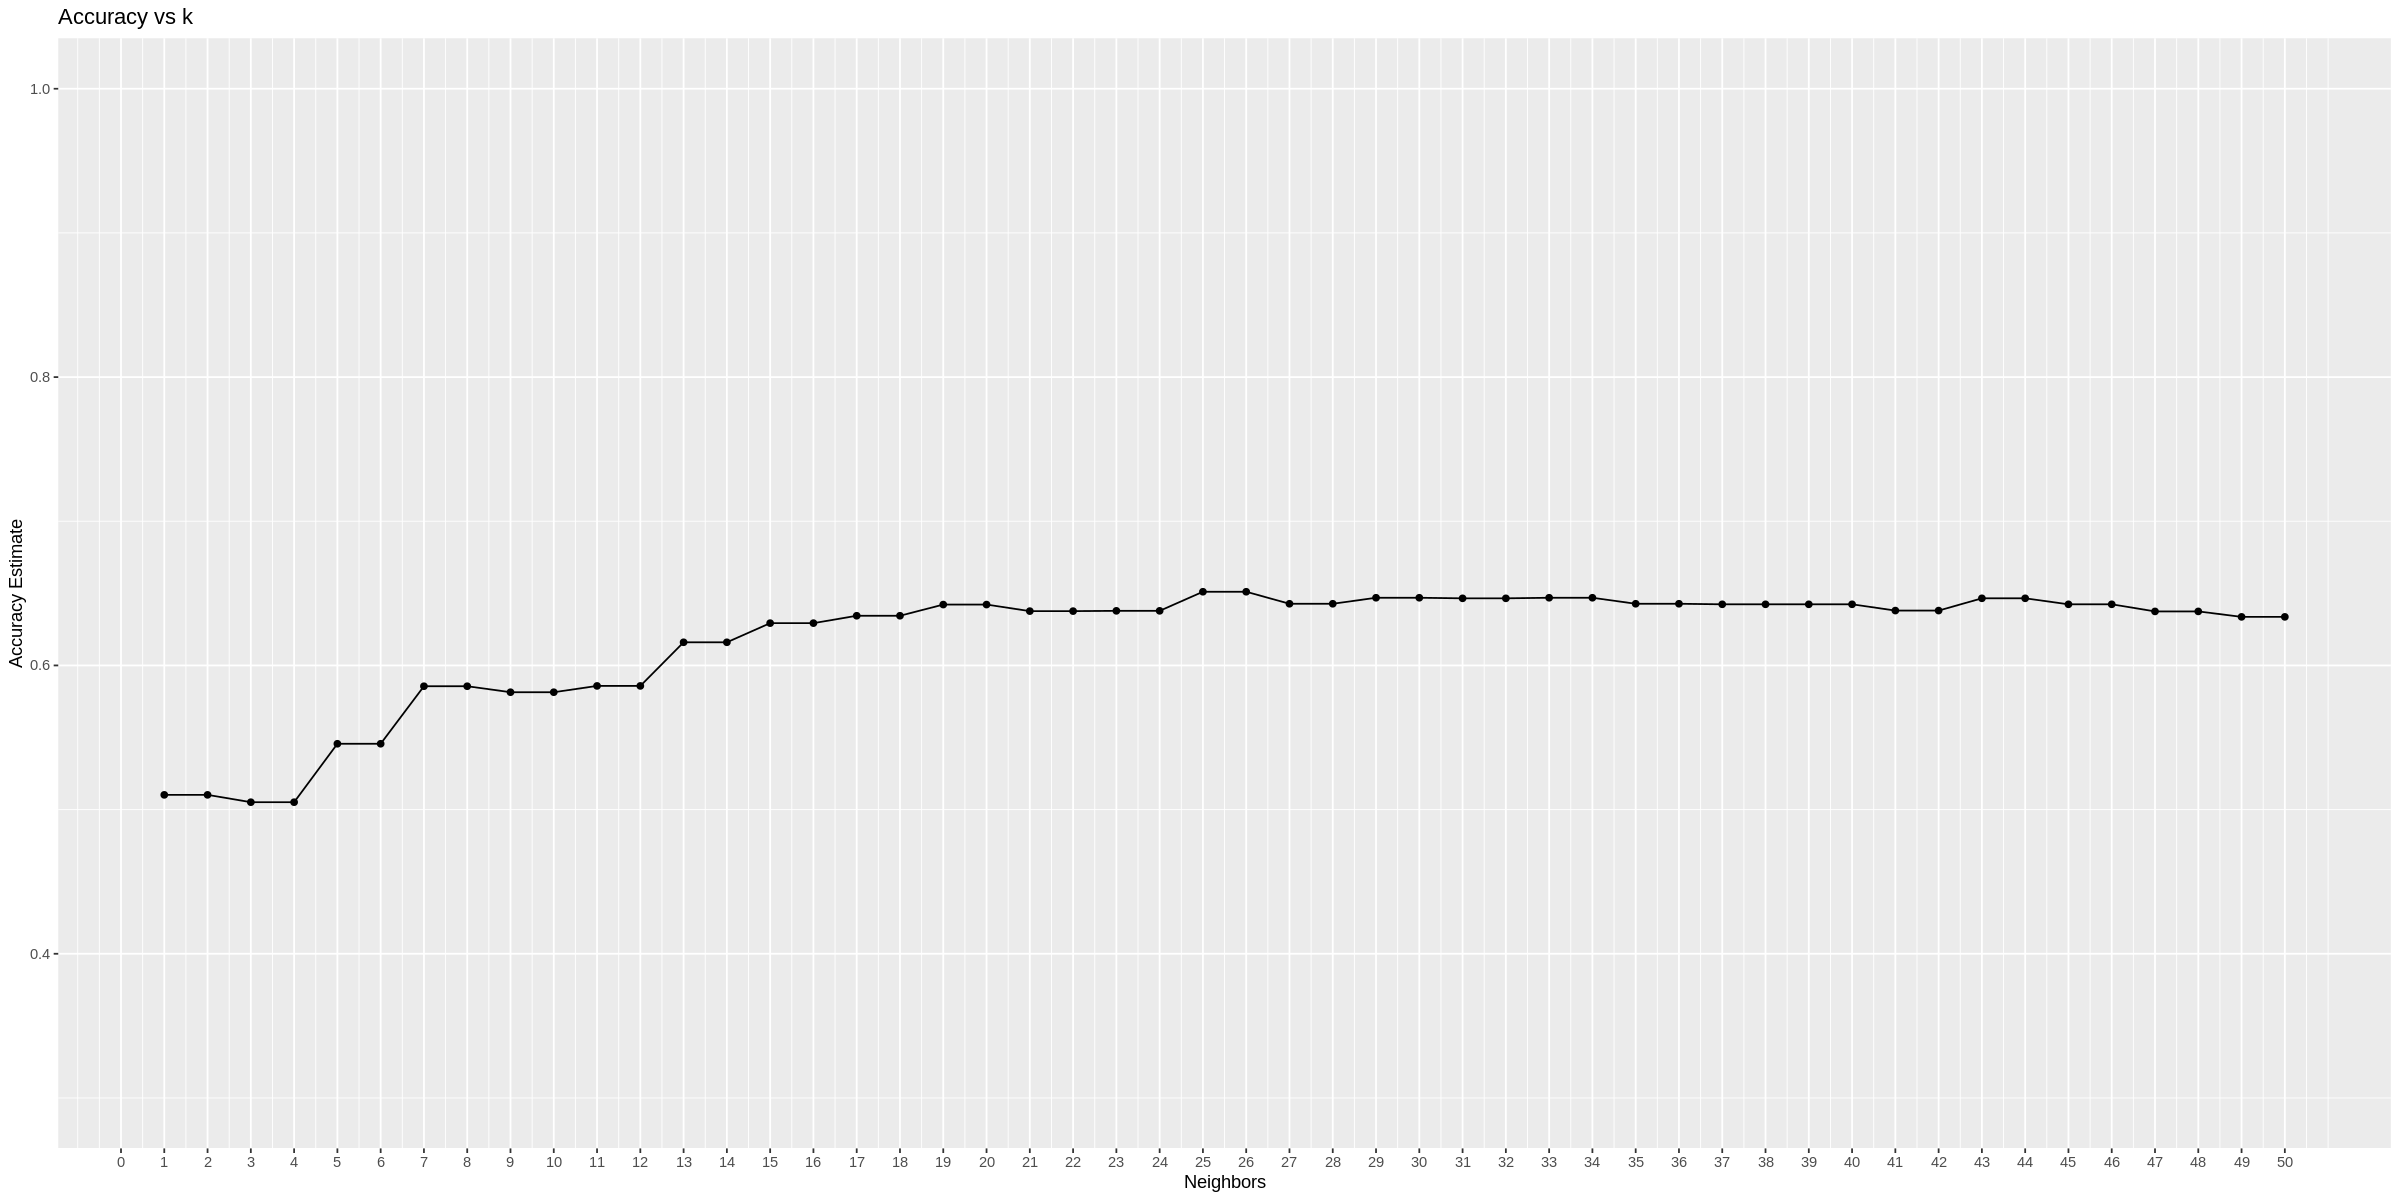

In [247]:
accuracy_versus_k

Figure 4.                                   
Line chart (with data points shown too, as dots), of estimated accuracy vs number of neighbours. This is used to determine the optimum number of neighbours (k value) to use in the final analysis.


.

### Building and testing the final classification model                                 
Following a similar process as the ““Trial” classification code”, the final classification model was created using the heart training data. The same recipe as the ““Trial” classification code “ was used (heart_recipe). A new model specification (knn_spec_final) was made with neighbors set to 25 (the k-value obtained in tuning), the “weight_func = “rectangular”” (straight-line distance was used to find the neighboring points and each neighbor had exactly 1 vote), and set to use KNN to perform classification. The recipe and model specification were plugged into a workflow to create our final KNN classification model. The model was used to predict the heart testing data and the accuracy was calculated (refer to the tibble and confusion matrix). 

A bar graph was used to further visualize the accuracy of our final classification model *refer to Figure 5*.

In [248]:
#final classification prediction with 36 neighbours, as determined by the accuracy vs neighbours plot

# recipe:
heart_recipe 

# model:
knn_spec_36 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 25) %>%
       set_engine('kknn') %>%
       set_mode('classification')

# workflow & fit:
heart_fit <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_spec_36) %>%
       fit(data = heart_train)

# predictions:
heart_test_predictions <- predict(heart_fit , heart_test) %>%
       bind_cols(heart_test) %>%
       mutate(correctness = diagnosis == .pred_class)

# accuracy assessment (tibble):
heart_prediction_accuracy <- heart_test_predictions %>%
         metrics(truth = diagnosis, estimate = .pred_class) 

# accuracy assessment (confusion matrix):
heart_mat <- heart_test_predictions %>% 
       conf_mat(truth = diagnosis, estimate = .pred_class)



Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [249]:
heart_test_predictions

.pred_class,age,resting_blood_pressure,cholesterol_level,diagnosis,correctness
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
0,41,130,204,0,TRUE
diseased,57,140,192,0,FALSE
0,48,110,229,diseased,FALSE
⋮,⋮,⋮,⋮,⋮,⋮
0,44,120,169,diseased,FALSE
0,45,110,264,diseased,FALSE
diseased,57,130,236,diseased,TRUE


Table 11.                                 
Predictions of the model (using the previously determined optimum k value) on the testing dataset.

In [250]:
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5733333
kap,binary,0.1519435


Table 12.                                       
Accuracy of the final prediction.

In [251]:
heart_mat

          Truth
Prediction  0 diseased
  0        22       13
  diseased 19       21

Table 13.                             
Confusion matrix showing the distribution of predictions vs actual diagnosis values.

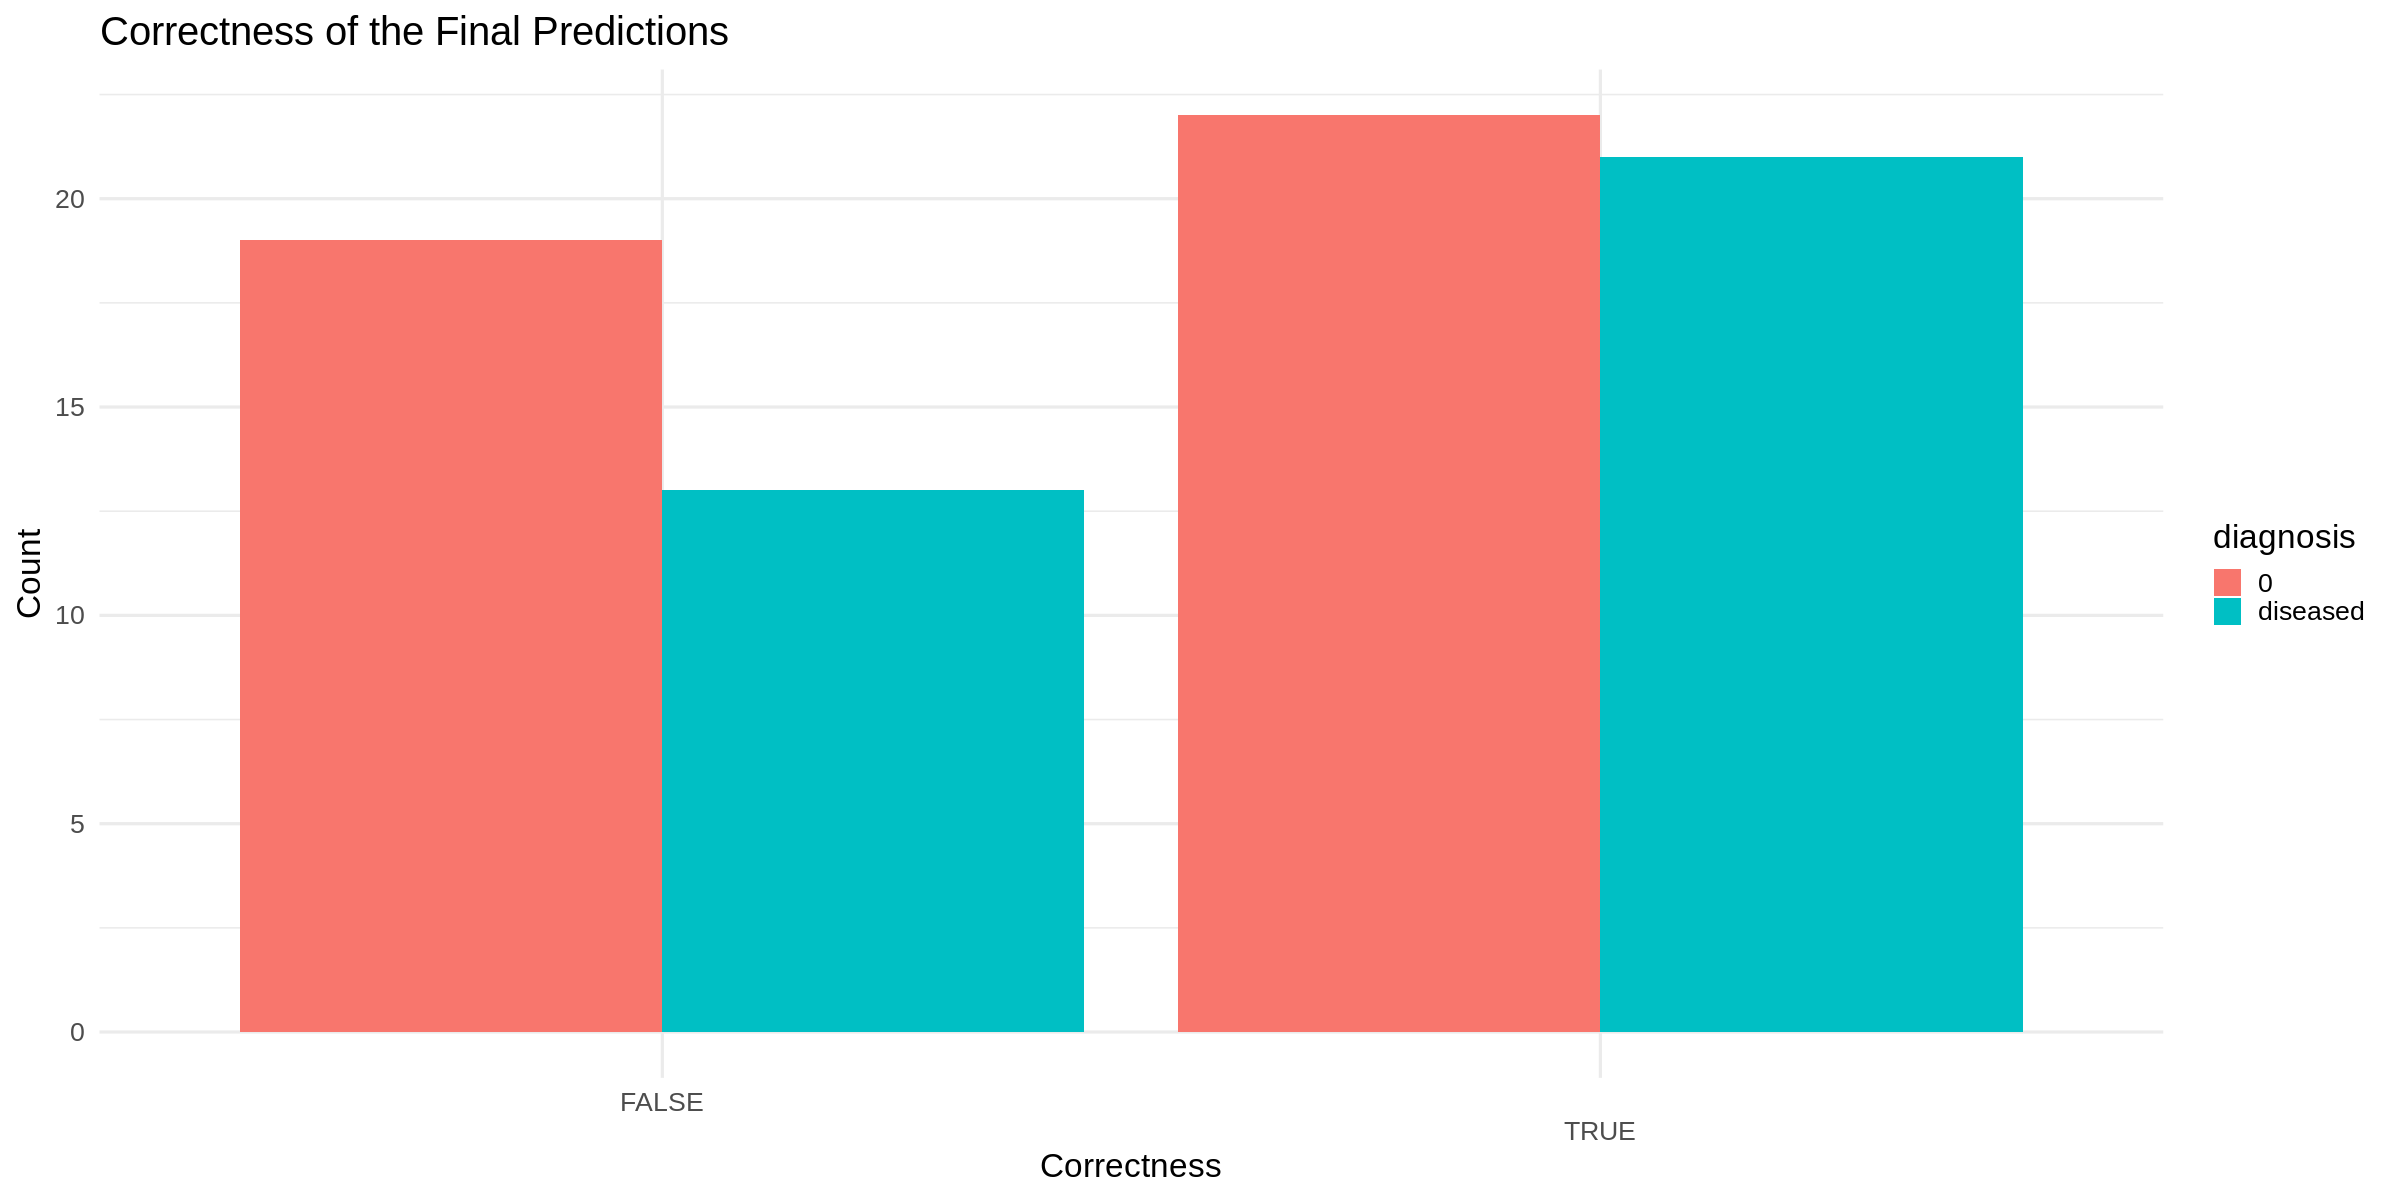

In [252]:
ggplot(heart_test_predictions) +
 geom_bar(aes(x = correctness, fill=diagnosis),position = position_dodge()) +
  theme_minimal(base_size = 20)+
  ylab("Count")+ xlab("Correctness") +
  scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
ggtitle("Correctness of the Final Predictions")

Figure 5.                               
Side-by-side bar plots visualization of the correctness of the final analysis. The number of observations correctly and incorrectly predicted by the model (with optimum k value) are plotted, with different colours representing the presence or absence of disease. In the 'Correctness' axis, observations whose diagnosis were correctly predicted are counted as 'TRUE', and those whose diagnosis were incorrectly predicted are counted as 'FALSE'.

In [253]:
final_visualization <- ggplot() +
                            geom_point(heart_test_predictions, mapping = aes(x = resting_blood_pressure, y = cholesterol_level, color = diagnosis), alpha = 0.75, size = 3) +
                            scale_color_manual(labels = c("True Healthy, Predicted Healthy", "True Diseased, Predicted Diseased"), values = c("red", "blue")) +

                            geom_point(heart_test_predictions, mapping = aes(x = resting_blood_pressure, y = cholesterol_level, color = .pred_class), alpha = 0.05, size = 30) +
                            labs(x = "Resting Blood Pressure (standardized)", y = "Cholesterol Level (standardized)", color = "Presence of Heart Disease") +
                            ggtitle("Predictions in Relation to BP and CH")

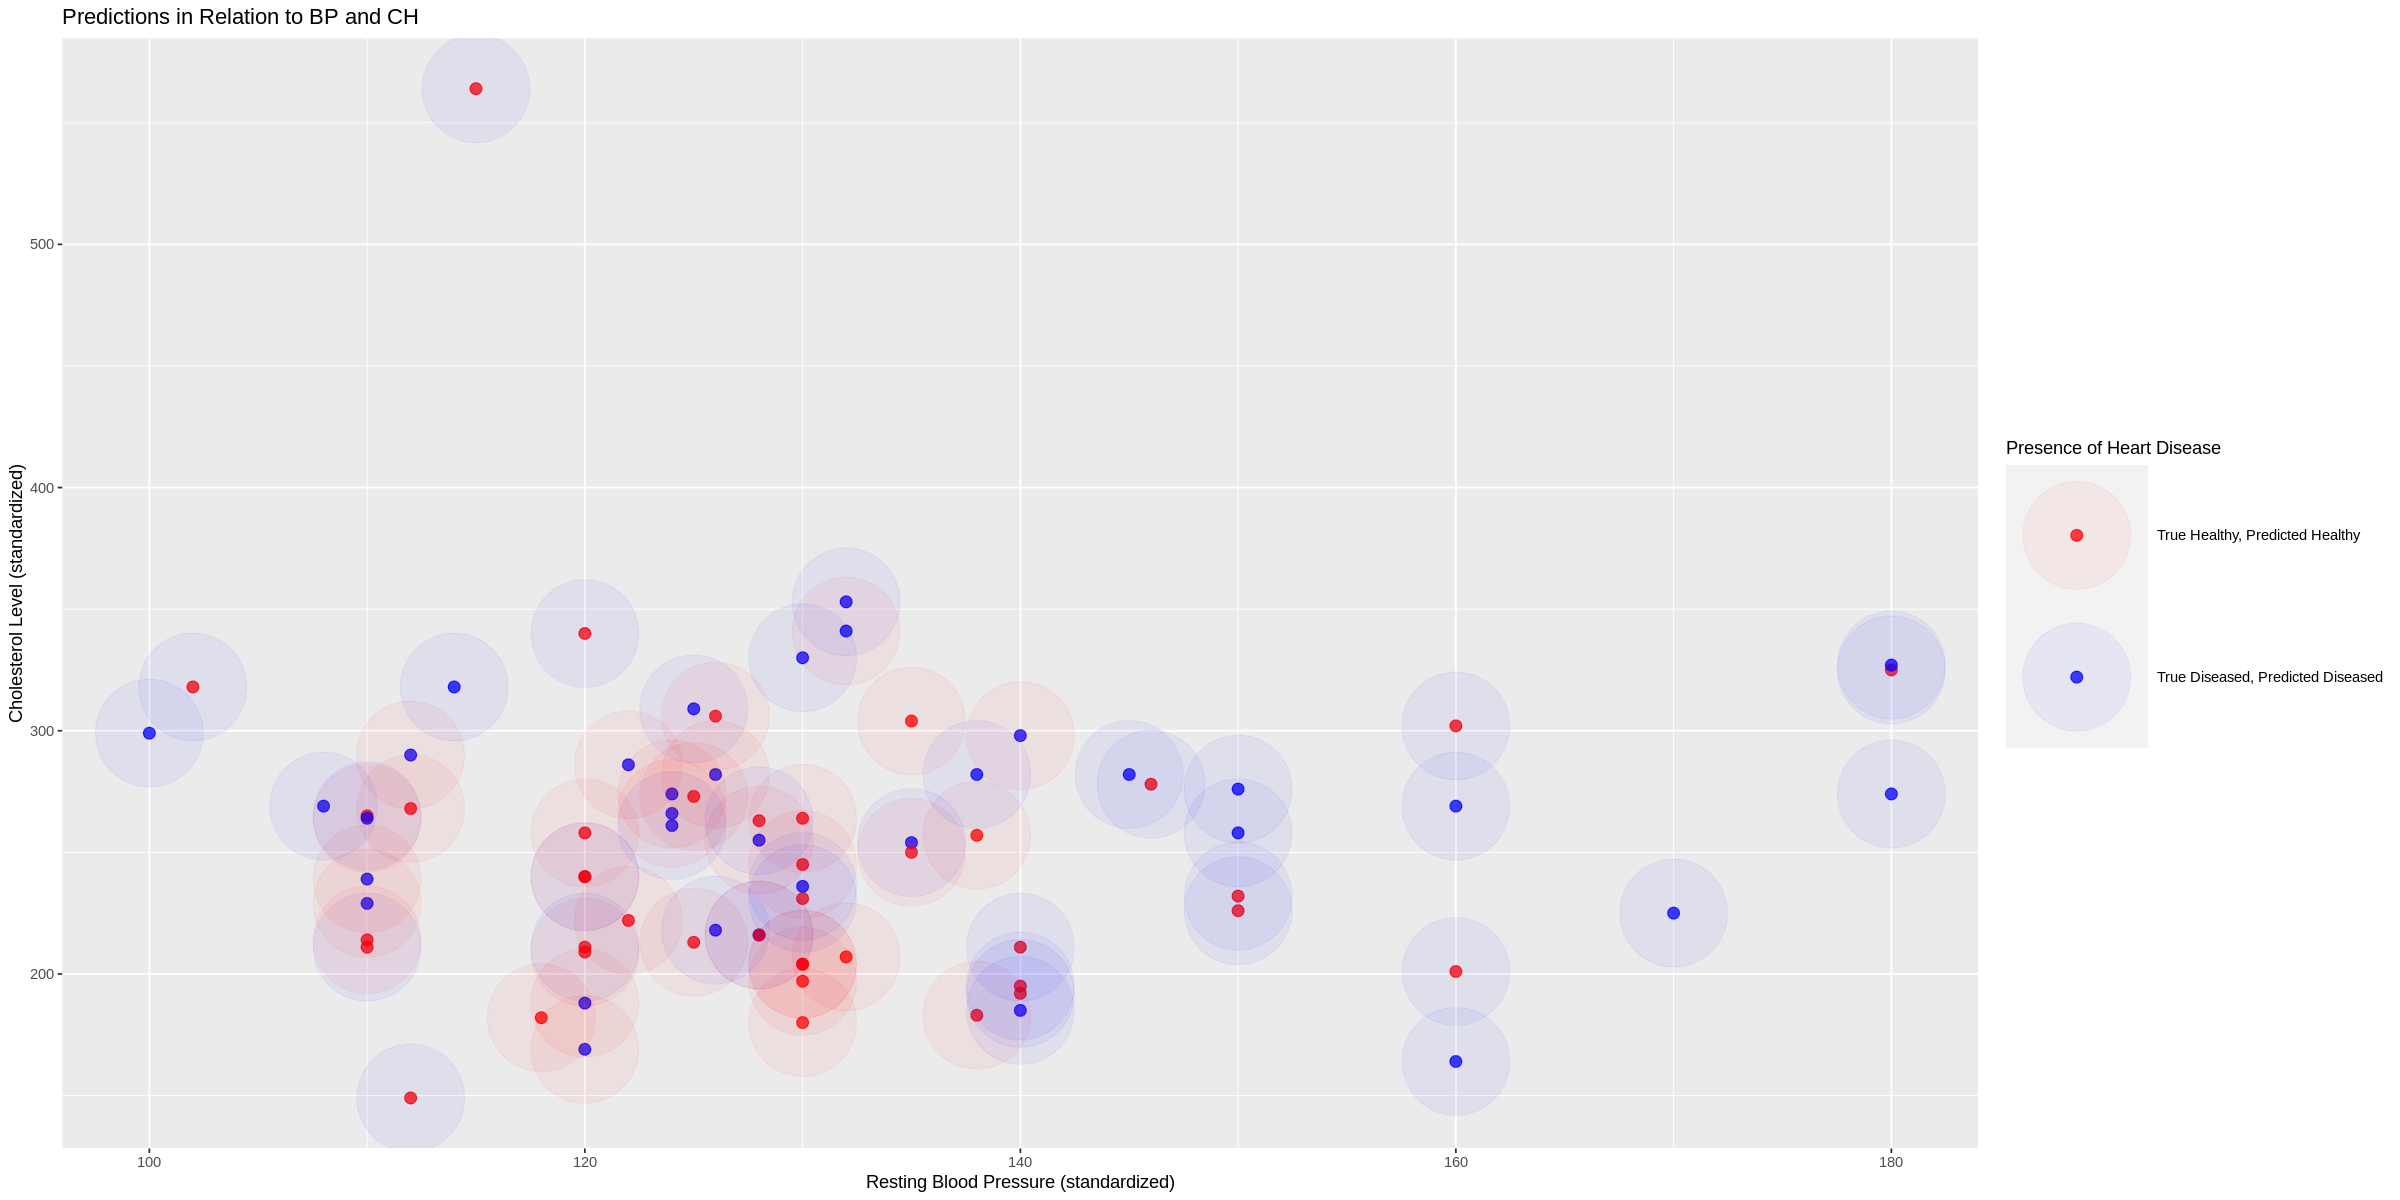

In [254]:
final_visualization

Figure 6.                             
Final visualization: plot of Cholesterol Level vs Resting Blood Pressure. Presence of Heart Disease is represented by color of the points. For each observation in the predictions of the final classification analysis, the true diagnosis is represented by the smaller dot at the center of the point, while the predicted value is represented by the transparent circle around the small dot. Matching colors between the small dot and circle indicate a correct prediction, and opposite colors indicate an incorrect prediction.

# *Results:*

After creating, tuning, and using the model on the appropriate parts of the dataset, our classification analysis is finished. The model successfully assigned a value of '0' (healthy) or 'diseased' (has heart disease) to each of the observations from the testing set, with an accuracy of about 57%. A visualization (Figure 5) has been created to show the distribution of correct vs incorrect predictions. Another one (Figure 6, the final visualization) has been created to display the full set of final predictions along with the true diagnosis of each.

# *Discussion:*                                 
Although our model did not predict the severity of the patient’s heart disease, and further, did not contribute to our expectation that heightened age, cholesterol level in the bloodstream, and resting blood pressure correlate to more severe heart disease, there are benefits to our research. From our data there was only minimal and no significant correlation that we were expecting to find.
While the data did not display our expectations, it may be adjusted to find alternate benefits. With some proposal adjustments future models may indicate whether the factors we perceive contributed to the overall presence of heart disease, as opposed to the severity. We believe that investigating this data may lead to more clear and promising results so that our model may be revised in the future. This would allow researchers in medicine to diagnose heart conditions at a faster rate and develop more effective treatment plans for heart diseases.                                                      

In conclusion, our model was able to predict the presence or absence of heart disease in the testing dataset with roughly 57% accuracy using the predictor variables of age, resting blood pressure, and cholesterol level.


# *Citations*

1. Damen, Johanna A, et al. “Prediction Models for Cardiovascular Disease Risk in the General Population: Systematic Review.” BMJ, 2016, p. i2416., https://doi.org/10.1136/bmj.i2416.

2. “High Cholesterol.” Mayo Clinic, Mayo Foundation for Medical Education and Research, 20 July 2021, https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=With%20high%20cholesterol%2C%20you%20can,a%20heart%20attack%20or%20stroke.

3. Weitzman, Dahlia, and Uri Goldbourt. “The Significance of Various Blood Pressure Indices for Long-Term Stroke, Coronary Heart Disease, and All-Cause Mortality in Men.” Stroke, vol. 37, no. 2, 2006, pp. 358–363., https://doi.org/10.1161/01.str.0000198869.84540.80.                    